In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyDOE
from multiprocessing import Process
from scipy.stats import norm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params, update_sev_prevalence
from analysis_helpers import poisson_waiting_function

from multi_group_simulation import MultiGroupSimulation

# Utility Functions

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

# Parameter Uncertainties

In [5]:
param_uncertainty = {
    'asymp_prob_mult': (24/47, 70/47), # Our nominal estimate for US population: 47%
    'inital_prev_mult': (0.5, 1.5),
    'R0': (1,4),
    'outside_inf_mult': (0.5, 1.5),
    'daily_self_report_prob': (0.22, 0.5),
    'ct_mult': (1,2),
    'ct_testing_ratio': (0.5, 1.5),
    'test_sensitivity': (0.4, 0.8),
    'test_noncompliance': (0.05, 0.15),
    'E_time': (1,3),
    'ID_time': (2,4),
    'Sy_time': (11,13),
    'virtual_noncompliance': (0.25, 0.75),
    'intermittent_non-compliance': (0.25,0.75),
    'virtual_r0_mult': (0.97, 1.5),
    'virtual_pop_size': (0,1), # Slider from min to max
}

uncertainty_params_list = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance', 'virtual_r0_mult',
                           'virtual_pop_size']

lb = list()
ub = list()

for param in uncertainty_params_list:
    lb.append(param_uncertainty[param][0])
    ub.append(param_uncertainty[param][1])

In [47]:
np.random.seed(2021)

dim = len(param_uncertainty.keys())
num_samples = 200
lhs_points = pyDOE.lhs(dim, samples=num_samples)

for i in range(dim):
    lhs_points[:, i] = (1 - lhs_points[:,i]) * lb[i] + lhs_points[:,i] * ub[i]

# lhs_points[:,1], (1 - lhs_points[:,1]) * lb[1] + lhs_points[:,1] * ub[1], lb[1], ub[1]
# lhs_points[:,15], 1 - lhs_points[:,15]
# lhs_points[:,7]

In [6]:
def get_nominal_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

In [7]:
def rescale_virtual_interaction_matrix(perc_compliant, group_sizes):
    interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                    [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                    [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                    [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                                   ])
    interaction_matrix[0,0] = (8.8651 + 2.2163) * (1 - perc_compliant)
    interaction_matrix[0,1] = (8.8651 + 2.2163) * (perc_compliant)
    interaction_matrix[1,1] = (8.8651 + 2.2163) * (perc_compliant)
    
    interaction_matrix[3,3] = (6.9926 + 1.7482) * (1 - perc_compliant)
    interaction_matrix[3,4] = (6.9926 + 1.7482) * perc_compliant
    interaction_matrix[4,4] = (6.9926 + 1.7482) * perc_compliant
    
    for i in range(interaction_matrix.shape[0]):
        for j in range(i):
            if ((i,j) == (0,0)) or ((i,j)==(0,1)) or ((i,j)==(1,1)):
                continue
            interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]
    return interaction_matrix


def get_virtual_params(perc_unmonitored, ug_pop, gs_other_pop):
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/virtual_instruction/'

    gs_research_params = load_params(base_directory + 'grad_research_virtual.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age_virtual.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age_virtual.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age_virtual.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community_virtual.yaml')[1]

    ug_off_campus_unmonitored_params = load_params(base_directory + 'ug_off_campus_unmonitored_virtual.yaml')[1]
    ug_off_campus_compliant_params = load_params(base_directory + 'ug_off_campus_compliant_virtual.yaml')[1]
    gs_other_unmonitored_params = load_params(base_directory + 'grad_other_unmonitored_virtual.yaml')[1]
    gs_other_compliant_params = load_params(base_directory + 'grad_other_compliant_virtual.yaml')[1]
    
#     total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
    ug_off_campus_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * ug_pop)
    ug_off_campus_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * ug_pop)
    
#     total_gs_other_pop = gs_other_unmonitored_params['population_size'] + gs_other_compliant_params['population_size']
    gs_other_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * gs_other_pop)
    gs_other_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * gs_other_pop)
    
    params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    group_names = ['UG unmonitored', 'UG compliant', 'GS research', 'GS unmonitored', 'GS compliant', 'F/S student', 'F/S non-student', 'F/S off', 'Ithaca']
    virtual_group_sizes = list()
    for params in params_list:
        virtual_group_sizes.append(params['population_size'])
    interaction_matrix = rescale_virtual_interaction_matrix(1 - perc_unmonitored, virtual_group_sizes)
    
    return params_list, interaction_matrix, group_names

In [9]:
get_nominal_params()[0][0]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 4167,
 'initial_ID_prevalence': 0.001558,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.018,
 'expected_contacts_per_day': 12.5,
 'daily_outside_infection_p': 1.2e-05,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.22,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<

In [8]:
def get_test_FNR(sensitivity, compliance):
    if 1 - (sensitivity * compliance) > 1:
        print(sensitivity, compliance)
    return 1 - (sensitivity * compliance)

def adjust_params(uncertainty_point):
    res_params_list, res_interaction_matrix, res_group_names = get_nominal_params()
    virtual_persistent_noncompliance = uncertainty_point[12]
    virtual_ug_pop = 4500 * (1 - uncertainty_point[15]) + 7950 * uncertainty_point[15]
    virtual_gs_other_pop = 4770 * (1 - uncertainty_point[15]) + 5850 * uncertainty_point[15]
    virtual_params_list, virtual_interaction_matrix, virtual_group_names = get_virtual_params(virtual_persistent_noncompliance, virtual_ug_pop, virtual_gs_other_pop)

    # Asmptomatic Prob Mult
    for params in res_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    for params in virtual_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    
    # Initial Prevalence Mult
    for params in res_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    for params in virtual_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    
    # R0 adjustment
    res_interaction_matrix *= uncertainty_point[2]/2.5
    virtual_interaction_matrix *= uncertainty_point[2] * uncertainty_point[14]/2.5
    
    # Outside inf mult
    for params in res_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    for params in virtual_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    
    # Daily self-report prob
    for params in res_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
    for params in virtual_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
        
    # CT mult
    for params in res_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    for params in virtual_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    
    # CT testing ratio
    for params in res_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    for params in virtual_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    
    # Test sensitivity and Test compliance (note: non-compliance is provided in uncertainty point)
    for params in res_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-uncertainty_point[8])
    for params in virtual_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-(uncertainty_point[13]))

    # E_time, ID_time, Sy_time
    for params in res_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
    
    for params in virtual_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        
    return (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names)

In [52]:
def run_simulation(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(uncertainty_point)

    # run simulations
    # Residential Simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
    
#     print(res_params_list[0]['severity_prevalence'])
#     for params in res_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
#     for params in virtual_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
    
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)
    
    # Running virtual sims
    print('Virtual Sim', point_id)
    virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(virtual_params_list, virtual_interaction_matrix, virtual_group_names, virtual_test_policy, 112, 50)
    
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
    file.close()    
    return

In [53]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_simulation, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [55]:
processes = []
for i in range(lhs_points.shape[0]):
# for i in range(20):
    point = lhs_points[i,:]
    p = run_new_process(point, 'apr_21_scenarios/point_'+str(i)+'.dill', i)
    processes.append(p)

# p = run_sims_new_process(ct_delay_sensitivity, 'res_inst_paper_graphs/apr_5_sens_ct_delay.dill')
# processes.append(p)
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

Res Sim 3
Res Sim 0
Res Sim 4
Res Sim 1
Res Sim 6
Res Sim 2
Res Sim 5
Res Sim 9
Res Sim 8
Res Sim 7
Res Sim 10
Res Sim 17
Res Sim 13
Res Sim 15
Res Sim 20
Res Sim 12
Res Sim 11
Res Sim 18
Res Sim 16
Res Sim 23
Res Sim 19
Res Sim 14
Res Sim 25
Res Sim 21
Res Sim 22
Res Sim 24
Res Sim 26
Res Sim 31
Res Sim 29
Res Sim 27
Res Sim 28
Res Sim 34
Res Sim 37
Res Sim 32
Res Sim 30
Res Sim 44
Res Sim 47
Res Sim 46
Res Sim 45
Res Sim 33
Res Sim 36
Res Sim 49
Res Sim 40
Res Sim 35
Res Sim 52
Res Sim 39
Res Sim 38
Res Sim 48
Res Sim 42
Res Sim 43
Res Sim 41
Res Sim 54
Res Sim 50
Res Sim 53
Res Sim 51
Res Sim 58
Res Sim 59
Res Sim 56
Res Sim 55
Res Sim 60
Res Sim 57
Res Sim 65
Res Sim 61
Res Sim 66
Res Sim 64
Res Sim 63
Res Sim 62
Res Sim 69
Res Sim 68
Res Sim 67
Res Sim 73
Res Sim 72
Res Sim 74
Res Sim 71
Res Sim 70
Res Sim 76
Res Sim 75
Res Sim 79
Res Sim 78
Res Sim 80
Res Sim 83
Res Sim 77
Res Sim 81
Res Sim 85
Res Sim 82
Res Sim 87
Res Sim 84
Res Sim 86
Res Sim 89
Res Sim 91
Res Sim 92
Res Sim 9

## Loading Results

In [9]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

In [7]:
file = open('apr_21_scenarios/point_0.dill', 'rb')
[uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
file.close()

In [8]:
get_stats(res_inf_matrix)

(array([ 90.9, 123.5, 175.5]), array([ 98.9, 112.5, 127.1]))

In [10]:
scenario_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_21_scenarios/point_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    scenario_data = scenario_data.append(new_row, ignore_index=True)

In [10]:
scenario_data

,asymp_prob_mult,inital_prev_mult,R0,outside_inf_mult,daily_self_report_prob,ct_mult,ct_testing_ratio,test_sensitivity,test_noncompliance,E_time,...,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90,vir_cornell_inf_10,vir_cornell_inf_50,vir_cornell_inf_90,vir_ithaca_inf_10,vir_ithaca_inf_50,vir_ithaca_inf_90
0,0.543174,0.701718,2.724921,0.536484,0.297794,1.974107,0.781738,0.729849,0.069377,1.965612,...,175.5,98.9,112.5,127.1,227.2,354.5,544.0,138.8,166.5,198.2
1,1.145449,0.597336,3.284122,1.032077,0.410879,1.235803,0.883811,0.570077,0.147978,2.340111,...,2233.1,283.1,343.5,397.3,8200.3,8404.0,8592.7,6285.3,6576.5,6947.6
2,0.639587,1.286964,3.416639,1.470871,0.359775,1.814202,0.815036,0.484307,0.094378,1.877289,...,1058.2,282.9,318.5,369.6,3817.9,4457.5,4929.1,1167.3,1408.5,1631.2
3,1.425116,1.322741,3.772779,1.201469,0.398205,1.838125,1.231949,0.663223,0.138962,2.531080,...,661.4,290.8,350.5,396.4,7757.7,7880.5,8103.1,3830.4,4036.0,4258.2
4,0.655389,1.413526,2.607427,0.791372,0.427719,1.246799,1.047118,0.714105,0.121955,2.386976,...,201.6,175.8,194.0,214.2,686.2,1496.5,2383.7,349.0,489.5,656.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.643856,0.736165,3.931574,1.381850,0.451496,1.853986,1.152028,0.691716,0.051221,2.434764,...,294.1,217.8,240.0,277.6,5891.3,6402.5,6744.4,1816.9,2061.5,2216.7
196,0.862189,1.268708,1.765069,1.104874,0.235067,1.983473,1.160404,0.409189,0.114033,1.766003,...,226.6,187.8,204.0,221.7,221.9,313.5,573.0,228.0,256.5,282.3
197,1.368636,0.860141,2.758014,1.339008,0.471445,1.331169,0.680461,0.460170,0.080654,2.362011,...,3070.2,365.9,443.0,508.1,8643.8,8802.0,8991.2,4837.2,5038.0,5306.1
198,1.164375,0.837899,1.596416,1.177922,0.302152,1.108240,1.397248,0.563945,0.138145,2.508129,...,262.1,180.8,202.5,228.4,1962.8,2481.0,2948.1,588.2,699.0,787.0


# Linear Regression results

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
scenario_data.columns

Index(['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult',
       'daily_self_report_prob', 'ct_mult', 'ct_testing_ratio',
       'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
       'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance',
       'virtual_r0_mult', 'virtual_pop_size', 'res_cornell_inf_10',
       'res_cornell_inf_50', 'res_cornell_inf_90', 'res_ithaca_inf_10',
       'res_ithaca_inf_50', 'res_ithaca_inf_90', 'vir_cornell_inf_10',
       'vir_cornell_inf_50', 'vir_cornell_inf_90', 'vir_ithaca_inf_10',
       'vir_ithaca_inf_50', 'vir_ithaca_inf_90'],
      dtype='object')

In [53]:
import statsmodels.api as sm
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = scenario_data[residential_columns]
Y_res_outcomes = np.array(scenario_data[[residential_target]])

X = sm.add_constant(X_res)
model = sm.OLS(Y_res_outcomes,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     16.30
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.21e-23
Time:                        12:12:30   Log-Likelihood:                -1631.0
No. Observations:                 200   AIC:                             3288.
Df Residuals:                     187   BIC:                             3331.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    995.8849   1513.837      0.658      0.511   -1990.509    3982.278
asymp_prob_mult          941.9148    229.475      4.105      0.000     489.222    1394.607
inital_prev_mult        -190.9972    229.833     -0.831      0.407    -644.397     262.402
R0                       666.9477     76.599      8.707      0.000     515.839     818.057
outside_inf_mult         174.1239    224.662      0.775      0.439    -269.074     617.322
daily_self_report_prob  -680.6892    771.987     -0.882      0.379   -2203.612     842.234
ct_mult                -1163.4178    235.061     -4.949      0.000   -1627.130    -699.705
ct_testing_ratio        -924.5224    223.899     -4.129      0.000   -1366.215    -482.830
test_sensitivity       -2727.6250    549.398     -4.965      0.000   -3811.439   -1643.811
test_noncompliance      2361.9812   2214.006      1.067      0.287   -2005.657    6729.619
E_time                    31.2164    110.004      0.284      0.777    -185.792     248.225
ID_time                 -161.4988    109.711     -1.472      0.143    -377.929      54.932
Sy_time                  152.5914    109.064      1.399      0.163     -62.563     367.746
==============================================================================
Omnibus:                      121.377   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.245
Skew:                           2.359   Prob(JB):                    8.11e-161
Kurtosis:                      11.137   Cond. No.                         471.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = np.matrix(scenario_data[residential_columns])
Y_res_outcomes = np.array(scenario_data[[residential_target]])

res_reg = LinearRegression().fit(X_res, Y_res_outcomes)

print("Intercept: {:.2f}".format(res_reg.intercept_[0]))
for col, coef in zip(residential_columns, res_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))

Intercept: 995.88
asymp_prob_mult: 941.91
inital_prev_mult: -191.00
R0: 666.95
outside_inf_mult: 174.12
daily_self_report_prob: -680.69
ct_mult: -1163.42
ct_testing_ratio: -924.52
test_sensitivity: -2727.62
test_noncompliance: 2361.98
E_time: 31.22
ID_time: -161.50
Sy_time: 152.59


### Predicting Residential

In [15]:
lr_results = {'Intercept': 995.88,
'asymp_prob_mult': 941.91,
'inital_prev_mult': -191.00,
'R0': 666.95,
'outside_inf_mult': 174.12,
'daily_self_report_prob': -680.69,
'ct_mult': -1163.42,
'ct_testing_ratio': -924.52,
'test_sensitivity': -2727.62,
'test_noncompliance': 2361.98,
'E_time': 31.22,
'ID_time': -161.50,
'Sy_time': 152.59}

## Calculating pessimistic scenario

In [16]:
range_dict = dict()
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']
for param in res_params:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in res_params:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in res_params:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.1537243162698188,
 'inital_prev_mult': 0.9674578245577438,
 'R0': 3.5227017549786117,
 'outside_inf_mult': 1.0296661967958411,
 'daily_self_report_prob': 0.3509075975984278,
 'ct_mult': 1.3017789646438236,
 'ct_testing_ratio': 0.8424822406289283,
 'test_sensitivity': 0.5256438210849786,
 'test_noncompliance': 0.10402429149482201,
 'E_time': 2.021276789891251,
 'ID_time': 2.8899358882947777,
 'Sy_time': 12.103991843994427}

In [17]:
centre_point = dict()
direction = dict()
for param in res_params:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [19]:
def generate_res_params_norm(conf_level):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + norm.ppf(conf_level) * direction[param]
    return new_params

def generate_res_params_scalar(mult):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + mult * direction[param] * norm.ppf(0.975)
    return new_params

def transform_res_param_dict_point(param_dict):
    new_point = list()
    for param in res_params:
        new_point.append(param_dict[param])
    new_point.append(0.5)
    new_point.append(0.5)
    new_point.append(0.97)
    new_point.append(0.5)
    return new_point

# pess_scenario, transform_res_param_dict_point(generate_res_params(0.975))

In [20]:
def run_res_simulation(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), _ = adjust_params(uncertainty_point)

    # run simulations
    # Residential Simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)
        
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix], file)
    file.close()
    return

In [21]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_res_simulation, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [22]:
processes = []

mult_levels = np.linspace(-1.2, 1.2, 25)

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    p = run_new_process(new_point, 'apr_22_pess_scenarios/res_pess_sensitivity_'+str(mult)+'.dill', mult)
    processes.append(p)



# for i in range(lhs_points.shape[0]):
# # for i in range(20):
#     point = lhs_points[i,:]
#     p = run_new_process(point, 'apr_22_pess_scenarios/res_pess_sensitivity_'+str(i)+'.dill', i)
#     processes.append(p)

# p = run_sims_new_process(ct_delay_sensitivity, 'res_inst_paper_graphs/apr_5_sens_ct_delay.dill')
# processes.append(p)
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 199
Res Sim 199


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 199


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
launched 25 processes
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199


In [23]:
pess_sens_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    file = open('apr_22_pess_scenarios/res_pess_sensitivity_'+str(mult)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    pess_sens_data = pess_sens_data.append(new_row, ignore_index=True)

In [24]:
pess_sens_data

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90
0,-1.2,93.9,110.0,123.0,140.0,148.5,164.1
1,-1.1,97.0,110.0,125.2,137.9,153.0,169.1
2,-1.0,101.8,113.0,126.2,143.9,157.0,173.1
3,-0.9,100.7,118.0,137.5,146.8,161.5,178.2
4,-0.8,107.9,123.5,148.4,142.9,169.0,185.2
5,-0.7,109.9,127.0,151.1,151.0,168.0,186.0
6,-0.6,116.6,135.0,159.1,149.9,170.0,187.2
7,-0.5,122.5,138.5,172.2,156.0,173.0,195.1
8,-0.4,125.0,154.5,180.1,160.6,176.5,201.0
9,-0.3,137.7,151.0,179.3,162.5,180.5,199.5


In [29]:
# Nominal Scenario
res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

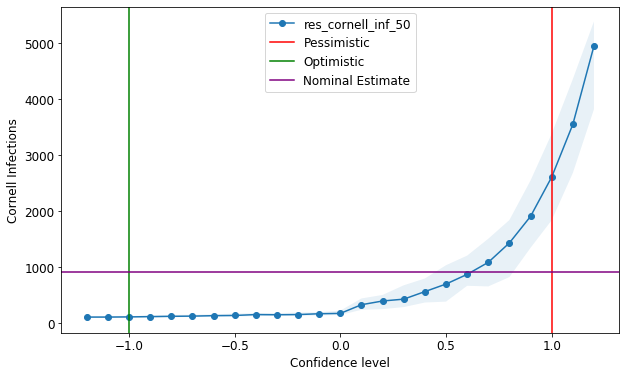

In [30]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res_cornell_inf_50', marker='o', data=pess_sens_data)
plt.fill_between(x='mult', y1='res_cornell_inf_10', y2='res_cornell_inf_90', alpha=0.1, data=pess_sens_data)

# plt.title('Cornell Infections')
plt.ylabel('Cornell Infections')
plt.xlabel('Confidence level')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Residential - Virtual

### Linear Regression

In [31]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
Y_res_outcomes = np.array(scenario_data[[residential_target]])

virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

X = np.matrix(scenario_data[virtual_columns])

Y_target = Y_res_outcomes - Y_vir_outcomes

reg = LinearRegression().fit(X, Y_res_outcomes - Y_target)

print("Intercept: {:.2f}".format(reg.intercept_[0]))
for col, coef in zip(virtual_columns, reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))

Intercept: -15398.37
asymp_prob_mult: 5040.46
inital_prev_mult: -604.22
R0: 2955.54
outside_inf_mult: 248.80
daily_self_report_prob: -2389.66
ct_mult: -1562.63
ct_testing_ratio: -1126.25
test_sensitivity: -2249.22
test_noncompliance: 166.63
E_time: -172.47
ID_time: 436.38
Sy_time: 121.72
virtual_noncompliance: 3712.20
intermittent_non-compliance: 1513.80
virtual_r0_mult: 5666.75
virtual_pop_size: 1174.99


In [54]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
Y_res_outcomes = np.array(scenario_data[[residential_target]])

virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

X = scenario_data[virtual_columns]

Y_target = Y_res_outcomes - Y_vir_outcomes

X = sm.add_constant(X)
model = sm.OLS(Y_target,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     42.54
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           6.09e-53
Time:                        13:11:44   Log-Likelihood:                -1718.5
No. Observations:                 200   AIC:                             3471.
Df Residuals:                     183   BIC:                             3527.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1.729e+04   2460.769      7.024      0.000    1.24e+04    2.21e+04
asymp_prob_mult             -4122.0772    361.994    -11.387      0.000   -4836.296   -3407.858
inital_prev_mult              420.7727    361.868      1.163      0.246    -293.197    1134.742
R0                          -2276.7187    120.322    -18.922      0.000   -2514.115   -2039.322
outside_inf_mult              -93.4250    354.677     -0.263      0.793    -793.207     606.357
daily_self_report_prob       1788.4518   1221.172      1.465      0.145    -620.936    4197.840
ct_mult                       444.6141    369.384      1.204      0.230    -284.184    1173.412
ct_testing_ratio              180.4051    359.169      0.502      0.616    -528.239     889.049
test_sensitivity             -511.4082    878.268     -0.582      0.561   -2244.242    1221.426
test_noncompliance           1734.4675   3507.732      0.494      0.622   -5186.330    8655.265
E_time                        194.2156    175.202      1.109      0.269    -151.460     539.891
ID_time                      -589.8021    173.052     -3.408      0.001    -931.235    -248.369
Sy_time                        -5.7650    174.184     -0.033      0.974    -349.431     337.901
virtual_noncompliance       -2774.9114    695.872     -3.988      0.000   -4147.874   -1401.948
intermittent_non-compliance -1654.8418    698.749     -2.368      0.019   -3033.482    -276.202
virtual_r0_mult             -6225.3427    645.328     -9.647      0.000   -7498.583   -4952.102
virtual_pop_size            -1513.9535    344.713     -4.392      0.000   -2194.076    -833.831
==============================================================================
Omnibus:                        6.125   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.116
Skew:                           0.428   Prob(JB):                       0.0470
Kurtosis:                       2.999   Cond. No.                         480.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
lr_results = {'Intercept': -15398.37,
'asymp_prob_mult': 5040.46,
'inital_prev_mult': -604.22,
'R0': 2955.54,
'outside_inf_mult': 248.80,
'daily_self_report_prob': -2389.66,
'ct_mult': -1562.63,
'ct_testing_ratio': -1126.25,
'test_sensitivity': -2249.22,
'test_noncompliance': 166.63,
'E_time': -172.47,
'ID_time': 436.38,
'Sy_time': 121.72,
'virtual_noncompliance': 3712.20,
'intermittent_non-compliance': 1513.80,
'virtual_r0_mult': 5666.75,
'virtual_pop_size': 1174.99}

### Calculating Pessimistic Scenario (v2: res - vir)

In [33]:
range_dict = dict()

for param in uncertainty_params_list:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in uncertainty_params_list:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in uncertainty_params_list:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.2170515418775607,
 'inital_prev_mult': 0.9728376180573575,
 'R0': 3.695782259674984,
 'outside_inf_mult': 1.0111846688744655,
 'daily_self_report_prob': 0.3515778119916065,
 'ct_mult': 1.4297528170285136,
 'ct_testing_ratio': 0.9493700429265811,
 'test_sensitivity': 0.5838220058354824,
 'test_noncompliance': 0.10007490761151737,
 'E_time': 1.9689868192800797,
 'ID_time': 3.07846890359227,
 'Sy_time': 12.02188742597106,
 'virtual_noncompliance': 0.541719983717635,
 'intermittent_non-compliance': 0.5170130142103755,
 'virtual_r0_mult': 1.3065580583060101,
 'virtual_pop_size': 0.5528210373022832}

In [34]:
centre_point = dict()
direction = dict()
for param in uncertainty_params_list:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [35]:
def generate_vir_params_norm(conf_level):
    new_params = dict()
    for param in uncertainty_params_list:
        new_params[param] = centre_point[param] + norm.ppf(conf_level) * direction[param]
    return new_params

def generate_vir_params_scalar(mult):
    new_params = dict()
    for param in uncertainty_params_list:
        new_params[param] = centre_point[param] + mult * direction[param] * norm.ppf(0.975)
    return new_params

def transform_vir_param_dict_point(param_dict):
    new_point = list()
    for param in uncertainty_params_list:
        new_point.append(param_dict[param])
    return new_point

# pess_scenario, transform_res_param_dict_point(generate_res_params(0.975))

In [36]:
def run_both_simulations(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), (vir_params_list, vir_interaction_matrix, vir_group_names) = adjust_params(uncertainty_point)

    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
        
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

    # Running virtual sims
    print('Virtual Sim', point_id)
    virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(vir_params_list, vir_interaction_matrix, vir_group_names, virtual_test_policy, 112, 50)
    
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
    file.close()
    return

In [37]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_both_simulations, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [38]:
processes = []

mult_levels = np.linspace(-1.2, 1.2, 25)

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    p = run_new_process(new_point, 'apr_22_pess_scenarios/res-vir_pess_sensitivity_'+str(mult)+'.dill', mult)
    processes.append(p)

print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim -1.2


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim -1.0


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim -0.8
Res Sim -1.0999999999999999


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim -0.8999999999999999
Res Sim -0.7
Res Sim -0.5
Res Sim -0.4
Res Sim -0.20000000000000007
Res Sim -0.6
Res Sim -0.30000000000000004
Res Sim -0.10000000000000009
Res Sim 0.09999999999999987
Res Sim 0.2999999999999998
Res Sim 0.0
Res Sim 0.19999999999999996
Res Sim 0.3999999999999999
launched 25 processes
Res Sim 0.5999999999999999
Res Sim 0.8999999999999997
Res Sim 0.5
Res Sim 0.7999999999999998
Res Sim 1.0999999999999999
Res Sim 0.9999999999999998
Res Sim 0.7
Res Sim 1.2
Virtual Sim 1.2
Virtual Sim 1.0999999999999999
Virtual Sim 0.2999999999999998
Virtual Sim 0.5
Virtual Sim 0.8999999999999997
Virtual Sim 0.5999999999999999
Virtual Sim 0.7999999999999998
Virtual Sim 0.7
Virtual Sim 0.9999999999999998
Virtual Sim -0.20000000000000007
Virtual Sim 0.09999999999999987
Virtual Sim -0.10000000000000009
Virtual Sim 0.19999999999999996
Virtual Sim 0.3999999999999999
Virtual Sim -0.6
Virtual Sim -0.8999999999999999
Virtual Sim 0.0
Virtual Sim -0.7
Virtual Sim -0.5
Virtual Sim -1.0
Virtual

### Loading Results

In [42]:
res_vir_pess = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for mult in mult_levels:
    file = open('apr_22_pess_scenarios/res-vir_pess_sensitivity_'+str(mult)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    res_vir_pess = res_vir_pess.append(new_row, ignore_index=True)

In [43]:
res_vir_pess

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90,vir_cornell_inf_10,vir_cornell_inf_50,vir_cornell_inf_90,vir_ithaca_inf_10,vir_ithaca_inf_50,vir_ithaca_inf_90
0,-1.2,90.8,103.5,120.2,139.0,151.0,159.2,78.8,96.0,108.2,142.9,154.5,164.2
1,-1.1,91.8,104.5,117.5,140.0,150.5,164.1,86.9,98.0,118.0,145.0,158.0,170.2
2,-1.0,95.9,108.0,124.0,139.0,152.0,166.2,88.7,111.5,130.1,148.0,161.5,178.2
3,-0.9,97.0,115.5,131.0,139.8,155.0,171.1,92.8,115.5,149.0,153.7,169.5,184.1
4,-0.8,98.9,121.0,142.0,146.0,159.0,178.1,99.9,119.0,144.1,157.0,170.0,190.2
5,-0.7,102.9,126.0,144.6,146.0,160.0,180.1,112.8,133.5,176.4,160.0,174.0,194.1
6,-0.6,106.8,125.0,149.0,152.8,168.0,185.3,117.0,152.0,209.4,165.8,183.0,201.2
7,-0.5,121.0,139.0,160.7,153.9,171.5,188.1,119.9,169.0,234.9,169.9,186.0,204.4
8,-0.4,122.9,152.0,187.5,159.0,178.0,192.2,152.5,204.5,261.3,172.9,192.5,214.1
9,-0.3,122.5,155.0,178.1,161.7,179.0,198.4,151.9,234.5,349.8,180.0,204.0,230.5


In [47]:
res_vir_pess['res-vir_cornell_inf_50'] = res_vir_pess['res_cornell_inf_50'] - res_vir_pess['vir_cornell_inf_50']
res_vir_pess['res-vir_cornell_inf_10'] = res_vir_pess['res_cornell_inf_10'] - res_vir_pess['vir_cornell_inf_10']
res_vir_pess['res-vir_cornell_inf_90'] = res_vir_pess['res_cornell_inf_90'] - res_vir_pess['vir_cornell_inf_90']

### Estimating Nominal Res - Virtual

In [44]:
# Nominal Scenario - already run for previous graph
# res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
# nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
# nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
virtual_params_list, virtual_interaction_matrix, virtual_group_names = get_virtual_params(0.5, 3468*2, 1434 * 2)
virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(virtual_params_list, virtual_interaction_matrix, virtual_group_names, virtual_test_policy, 112, 50)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


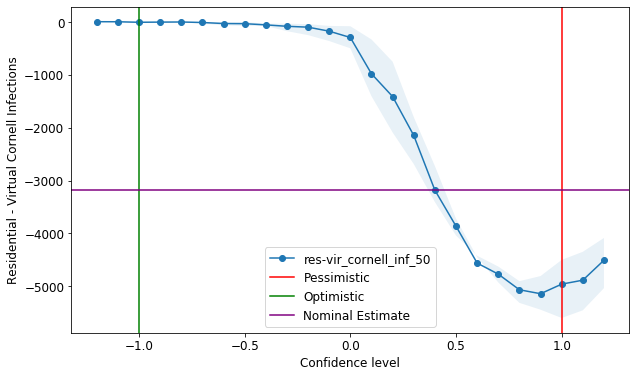

In [49]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res-vir_cornell_inf_50', marker='o', data=res_vir_pess)
plt.fill_between(x='mult', y1='res-vir_cornell_inf_10', y2='res-vir_cornell_inf_90', alpha=0.1, data=res_vir_pess)

# plt.title('Cornell Infections')
plt.ylabel('Residential - Virtual Cornell Infections')
plt.xlabel('Confidence level')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_inf_matrix)[0][1] - get_stats(virtual_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Old Code

In [22]:
# conf_levels = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]
# conf_data = pd.DataFrame(columns=['conf_level']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

mult_levels = np.linspace(-1.2, 1.2, 25)
mult_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    print(mult)
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    mult_data = mult_data.append(new_row, ignore_index=True)

-1.2


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


-1.0999999999999999
-1.0
-0.8999999999999999
-0.8
-0.7
-0.6
-0.5
-0.4
-0.30000000000000004
-0.20000000000000007
-0.10000000000000009
0.0
0.09999999999999987
0.19999999999999996
0.2999999999999998
0.3999999999999999
0.5
0.5999999999999999
0.7
0.7999999999999998
0.8999999999999997
0.9999999999999998
1.0999999999999999
1.2


In [23]:
mult_data

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90
0,-1.2,85.0,95.0,108.1,116.0,127.5,145.0
1,-1.1,86.8,98.0,112.0,121.0,132.0,142.8
2,-1.0,90.0,102.5,119.1,132.9,139.5,154.4
3,-0.9,98.0,107.5,123.0,126.0,145.5,155.2
4,-0.8,93.8,111.5,132.2,132.9,142.0,163.0
5,-0.7,101.0,115.5,141.1,134.9,148.5,164.2
6,-0.6,110.4,129.0,152.1,144.9,159.0,172.2
7,-0.5,113.9,130.5,147.2,145.2,164.0,178.3
8,-0.4,122.0,146.5,169.0,150.8,168.5,184.3
9,-0.3,127.0,159.5,187.0,154.8,176.5,193.3


In [25]:
# Nominal Scenario
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


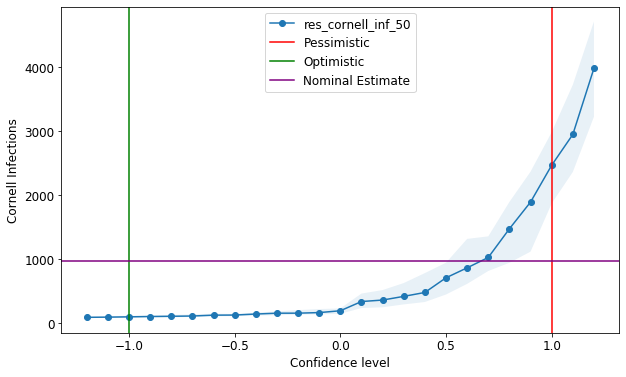

In [29]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res_cornell_inf_50', marker='o', data=mult_data)
plt.fill_between(x='mult', y1='res_cornell_inf_10', y2='res_cornell_inf_90', alpha=0.1, data=mult_data)

# plt.title('Cornell Infections')
plt.ylabel('Cornell Infections')
plt.xlabel('Confidence level')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Proposal 1
# x-axis: Mass in hyper-ellipsoid, y: performance of worst configuration in the hyper ellipsoid (according to linear model), centre: 0

# Describe graph as 0 - 1 being ellipsoid, 0.5 is centre. Beyond 0, 1 is beyond ellipsoid
# Linear transformation of x-axis: (z-score). 0 is centre, -1 is 1 sd optimistic, +1 is 1 sd pessimistic

# (-1) to 1 where -1 is optimistic, +1 is pessimistic

# Proposal 2
# hyperplane orthogonal to line, integrate probability density over half-space

# Residential - Virtual

In [30]:
virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
X_vir = np.matrix(scenario_data[virtual_columns])
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

Y_vir_target = Y_res_outcomes - Y_vir_outcomes

vir_reg = LinearRegression().fit(X_vir, Y_vir_target)
print("Intercept: {:.2f}".format(vir_reg.intercept_[0]))
for col, coef in zip(virtual_columns, vir_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))


Intercept: 10309.46
asymp_prob_mult: -3676.94
inital_prev_mult: 718.62
R0: -1855.12
outside_inf_mult: -46.64
daily_self_report_prob: 1292.63
ct_mult: 1018.80
ct_testing_ratio: 391.35
test_sensitivity: 1331.83
test_noncompliance: 111.85
E_time: 226.41
ID_time: -156.81
Sy_time: -31.22
virtual_noncompliance: -3053.47
intermittent_non-compliance: -316.40
virtual_r0_mult: -4391.05
virtual_pop_size: 5.12


In [ ]:
virtual_lr_results = {'Intercept': -110.67,
'asymp_prob_mult': 164.51,
'inital_prev_mult': 42.82,
'R0': 107.74,
'outside_inf_mult': 138.03,
'daily_self_report_prob': -165.30,
'ct_mult': -160.51,
'ct_testing_ratio': -83.95,
'test_sensitivity': -255.78,
'test_noncompliance': 303.68,
'E_time': 6.59,
'ID_time': -8.20,
'Sy_time': 22.56}

In [41]:
pess_scenario_point = list()
for param in res_params:
    pess_scenario_point.append(pess_scenario[param])
for _ in range(4):
    pess_scenario_point.append(0)
(res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(pess_scenario_point)
res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


In [42]:
get_stats(res_inf_matrix)

(array([1453.5, 1893.5, 2479.1]), array([511.8, 568. , 649. ]))

In [43]:
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

In [44]:
get_stats(nom_inf_matrix)

(array([ 616.1,  974.5, 1304. ]), array([261.9, 298. , 346.5]))

In [ ]:
alpha_ellipsoid = 0.95
def get_alpha_coords(alpha):
    for param in param_uncertainty.keys():
        LB = param_uncertainty[param][0]
        UB = param_uncertainty[param][1]
        new_value = LB + (UB-LB) * (norm.ppf(1+alpha/2) / norm.ppf(1+alpha_ellipsoid/2))
        